# RecoFlow Example

Matrix Factorisation - Linear with Bias: This is the classical collaborative filtering model with addition of bias

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
#from IPython.display import SVG, display
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

### Prepare the data

In [4]:
df_ratings = pd.read_csv("data/ratings.csv")
df_items= pd.read_csv("data/items.csv")

In [5]:
from recoflow.preprocessing import EncodeUserItem

Using TensorFlow backend.


In [6]:
interaction, n_users, n_items, user_encoder, item_encoder = EncodeUserItem(df_ratings, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1682


In [7]:
interaction.head()

,user_id,movie_id,RATING,TIMESTAMP,USER,ITEM
0,196,242,3,881250949,195,241
1,186,302,3,891717742,185,301
2,22,377,1,878887116,21,376
3,244,51,2,880606923,243,50
4,166,346,1,886397596,165,345


In [8]:
n_users, n_items

(943, 1682)

In [9]:
max_rating = interaction.RATING.max()
min_rating = interaction.RATING.min()
min_rating, max_rating

(1, 5)

In [10]:
from recoflow.preprocessing import RandomSplit, StratifiedSplit, ChronoSplit

In [11]:
# Data Splitting
train, test = StratifiedSplit(interaction, [0.8, 0.2], by="USER")

In [12]:
train.shape, test.shape

((80000, 7), (20000, 7))

## Explicit Matrix Factorisation 

This is a model with User and Item Embedding Dot Product + adjustment for user bias

### Build the Model

In [13]:
from recoflow.models import ExplicitMatrixFactorisationBias
from recoflow import vis

In [14]:
n_factors = 40
model = ExplicitMatrixFactorisationBias(n_users, n_items, n_factors, max_rating, min_rating)

In [15]:
model.summary()

Model: "ExplicitMatrixFactorisationBias"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
ItemEmbedding (Embedding)       (None, 1, 40)        67280       Item[0][0]                       
__________________________________________________________________________________________________
UserEmbedding (Embedding)       (None, 1, 40)        37720       User[0][0]                       
____________________________________________________________________

In [16]:
from keras.utils import plot_model

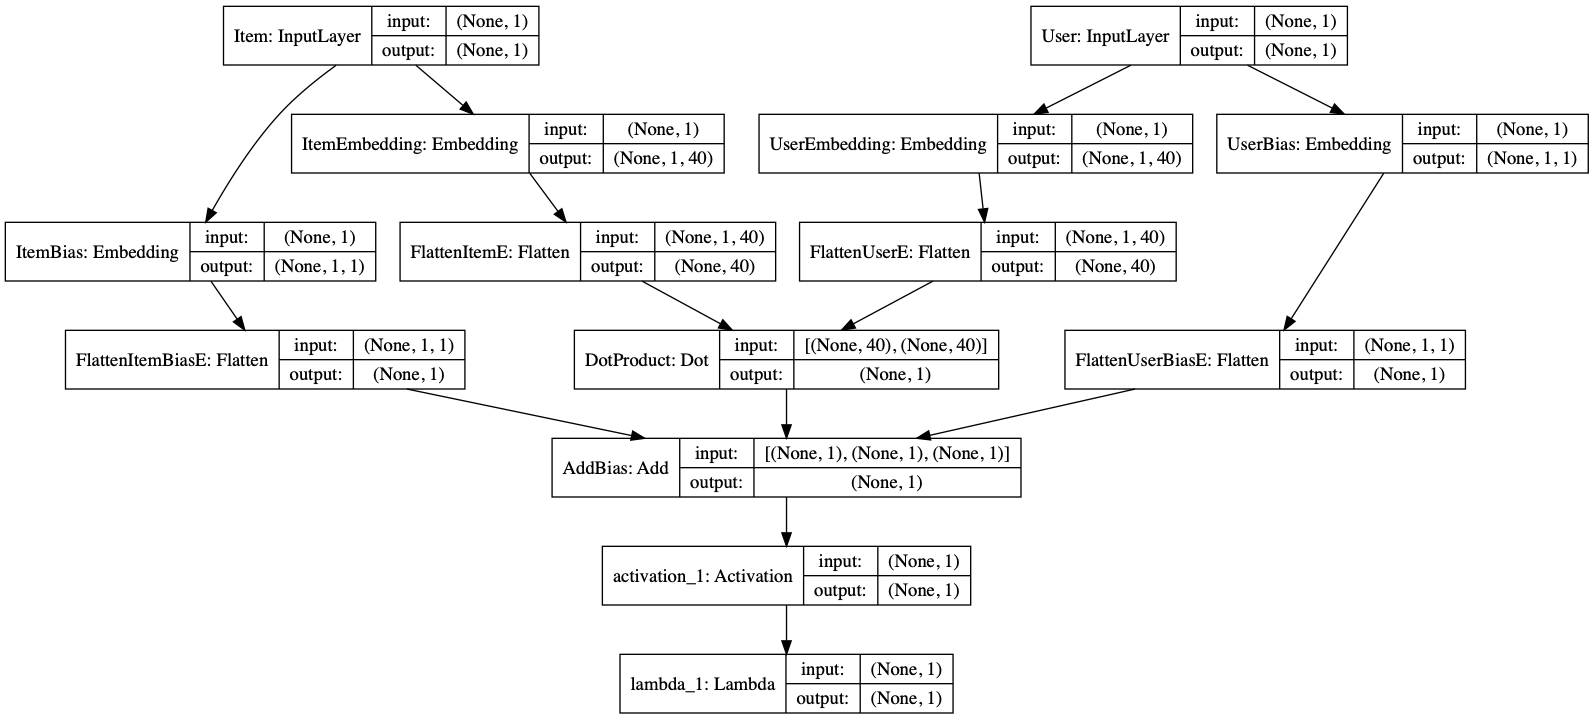

In [17]:
plot_model(model, show_layer_names=True, show_shapes=True)

### Train the Model

In [18]:
from recoflow.utils import CreateDirectory

In [19]:
CreateDirectory('models')

Directory already exists /Users/amitkaps/Documents/github/recommendation/MovieLens/models


In [20]:
from keras.callbacks import ModelCheckpoint, History

In [21]:
checkpointer = ModelCheckpoint(filepath="models/EMFBiasWeights.hdf5", verbose=1, save_best_only=True)
modelmetrics = History()

In [22]:
%%timeit -n1 -r1 -o
model.fit([train.USER, train.ITEM], train.RATING, batch_size=256, epochs=2, verbose=1, 
                   validation_data=([test.USER, test.ITEM], test.RATING), 
                   callbacks=[checkpointer, modelmetrics])


Train on 80000 samples, validate on 20000 samples
Epoch 1/2
80000/80000 [==============================] - 2s 24us/step - loss: 1.4239 - val_loss: 1.3137

Epoch 00001: val_loss improved from inf to 1.31371, saving model to models/EMFBiasWeights.hdf5
Epoch 2/2
80000/80000 [==============================] - 2s 21us/step - loss: 1.1137 - val_loss: 1.0051

Epoch 00002: val_loss improved from 1.31371 to 1.00510, saving model to models/EMFBiasWeights.hdf5
4.66 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 4.66 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [23]:
training_time = _.timings[0]

In [24]:
training_time

4.662544323000002

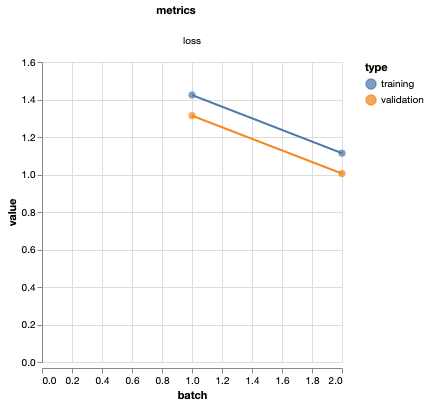

In [25]:
vis.metrics(modelmetrics.history)

### Score the Model

In [26]:
model.load_weights("models/EMFBiasWeights.hdf5")

In [27]:
score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

20000/20000 [==============================] - 1s 42us/step


1.0050974471092224

### Evaluate the Model

In [28]:
from timeit import default_timer
from recoflow.recommend import GetPredictions, GetRankingTopK

In [29]:
%%time
predictions = GetPredictions(model, interaction)

CPU times: user 38.5 s, sys: 4.43 s, total: 43 s
Wall time: 31.9 s


In [30]:
predictions.shape

(1586126, 3)

In [32]:
%%time
# Recommendation for Top10K
ranking_topk = GetRankingTopK(model, interaction, train, k=5)

CPU times: user 38.7 s, sys: 3.87 s, total: 42.6 s
Wall time: 36 s


In [36]:
%%time
start_time = default_timer()
end_time = default_timer()
print(end_time-start_time)

8.899999954792293e-07
CPU times: user 242 µs, sys: 171 µs, total: 413 µs
Wall time: 732 µs


In [37]:
predictions.head()

,USER,ITEM,RATING
0,195,241,3.468970
1,195,301,3.623670
2,195,376,2.903128
3,195,50,3.285254
4,195,345,3.357141


In [38]:
ranking_topk.head(10)

,USER,ITEM,RATING,rank
0,0,482,4.216309,1
1,0,317,4.213898,2
2,0,126,4.204764,3
3,0,356,4.192140,4
4,0,171,4.138190,5
5,1,173,3.796790,1
6,1,97,3.793300,2
7,1,180,3.792967,3
8,1,99,3.780123,4
9,1,63,3.779160,5


In [39]:
from recoflow.metrics import MeanAbsoluteError, MeanSquaredError, RootMeanSquaredError
from recoflow.metrics import PrecisionK, RecallK, NDCGK, MeanAveragePrecisionK, MeanReciprocalRankK

In [40]:
( MeanSquaredError(test, predictions), 
  RootMeanSquaredError(test, predictions), 
  MeanAbsoluteError(test, predictions)
)

(1.0044325255806545, 1.00221381230786, 0.8131720583081246)

In [43]:
def ranking_metrics(test, ranking_topk, k=5):
    
    return ( PrecisionK(test, predictions, k),
  RecallK(test, predictions,k),
  NDCGK(test, predictions,k),
  MeanAveragePrecisionK(test, predictions, k),
  MeanReciprocalRankK(test, predictions,k)
)

In [44]:
ranking_metrics(test, predictions)

(0.09247083775185579,
 0.03109213672521069,
 0.09915847189580687,
 0.017518656815744993,
 0.0530682219865677)

In [45]:
ranking_metrics(test, ranking_topk)

(0.09247083775185579,
 0.03109213672521069,
 0.09915847189580687,
 0.017518656815744993,
 0.0530682219865677)

In [51]:
ranking_metrics(test1, prediction1)

(1.0, 0.8333333333333334, 1.0, 0.8333333333333334, 1.0)

In [47]:
test1 = test[test.USER == 1]
prediction1 = predictions[predictions.USER==1]

In [54]:
test1.ITEM.tolist()

[99, 126, 284, 288, 303, 271, 277, 287, 285, 274, 301, 295]

In [55]:
prediction1.ITEM.tolist()

[99, 126, 284, 288, 303, 271, 277, 287, 285, 274, 301, 295]

In [ ]:
from recoflow.metrics import _GetHitDF

In [ ]:
df_hit, df_hit_count, n_users = _GetHitDF(test, predictions, 5)

In [ ]:
test.head()

In [ ]:
train[train.USER == 0].count()

In [ ]:
test[test.USER ==0].count()

In [ ]:
df_hit[df_hit.USER ==0]

In [ ]:
# Calculate Reciprocal Rank
df_hit_sorted = df_hit.copy()
df_hit_sorted["rRank"] = (df_hit_sorted.groupby("USER").cumcount() + 1) / df_hit_sorted["rank"]
df_hit_sorted = df_hit_sorted.groupby("USER").agg({"rRank": "sum"}).reset_index()

In [ ]:
df_hit_sorted.

In [ ]:
df_hit_sorted["rRank"].sum() / n_users

In [ ]:
#from reco.evaluate import get_embedding, get_predictions, recommend_topk
#from reco.evaluate import precision_at_k, recall_at_k, ndcg_at_k

In [ ]:
from recoflow.recommend import UserEmbedding, ItemEmbedding

In [ ]:
item_embedding = ItemEmbedding(model, "ItemEmbedding")
user_embedding = UserEmbedding(model, "UserEmbedding")

In [55]:
item_embedding.shape

(1682, 40)

In [56]:
from sklearn.neighbors import NearestNeighbors

In [57]:
def GetSimilar(embedding, k):
    model_similar_items = NearestNeighbors(n_neighbors=k, algorithm="ball_tree").fit(embedding)
    distances, indices = model_similar_items.kneighbors(embedding)
    
    return distances, indices

In [58]:
model_similar_items = NearestNeighbors(n_neighbors=10, metric="cosine").fit(item_embedding)
distances, indices = model_similar_items.kneighbors(item_embedding)
    

In [59]:
indices[0]

array([   0,  173,  171,   49,   70,  172,   95,  165,   94, 1049])

In [60]:
def show_similar(item_index, item_similar_indices, item_encoder):
        
    s = item_similar_indices[item_index]
    movie_ids = item_encoder.inverse_transform(s)

    images = []
    for movie_id in movie_ids:
        img_path = 'data/posters/' + str(movie_id) + '.jpg'
        images.append(mpimg.imread(img_path))

    plt.figure(figsize=(20,10))
    columns = 5
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.axis('off')
        plt.imshow(image)

In [61]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL

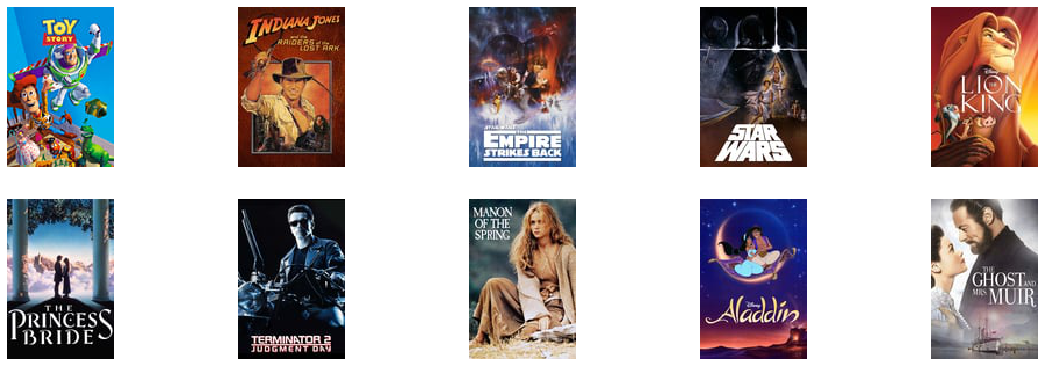

In [62]:
show_similar(0, indices, item_encoder)

In [ ]:
GetSimilar

In [80]:
%%time
predictions = get_predictions(model, DATA)

CPU times: user 36 s, sys: 4.9 s, total: 40.9 s
Wall time: 28.7 s


In [81]:
predictions.head()

,USER,ITEM,RATING_PRED
0,195,241,3.992213
1,195,301,4.169230
2,195,376,2.630966
3,195,50,3.447595
4,195,345,3.718785


In [82]:
%%time
# Recommendation for Top10K
ranking_topk = recommend_topk(model, DATA, train, k=5)

CPU times: user 42.6 s, sys: 5.13 s, total: 47.7 s
Wall time: 37.3 s


In [83]:
eval_precision = precision_at_k(test, ranking_topk, k=10)
eval_recall = recall_at_k(test, ranking_topk, k=10)
eval_ndcg = ndcg_at_k(test, ranking_topk, k=10)

print("NDCG@K:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

NDCG@K:	0.096059
Precision@K:	0.064509
Recall@K:	0.037104


### Get Similar Items

In [84]:
from reco.recommend import get_similar, show_similar

In [85]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

CPU times: user 160 ms, sys: 4.39 ms, total: 164 ms
Wall time: 173 ms


In [86]:
item_similar_indices

array([[   0,   78,  163, 1188,  731],
       [   1,  917, 1041,  773,  780],
       [   2, 1464, 1619,  795,  985],
       ...,
       [1679, 1381, 1625, 1666, 1673],
       [1680, 1666, 1678, 1667, 1381],
       [1681, 1328, 1447, 1593, 1365]])

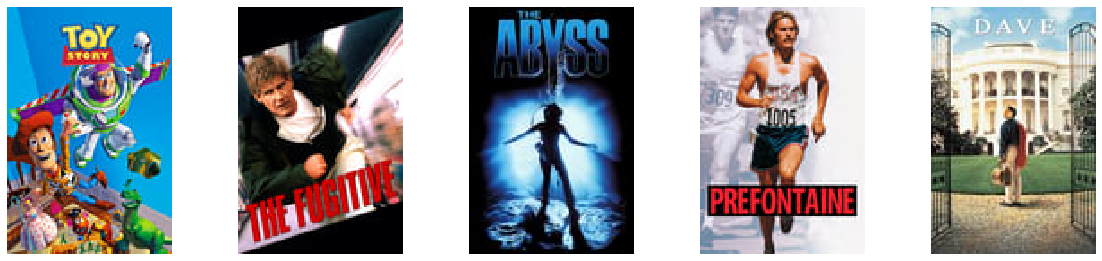

In [87]:
show_similar(0, item_similar_indices, item_encoder)

# Implicit

In [106]:
from scipy.sparse import coo_matrix

In [107]:
data = pd.read_csv("data/ratings.csv")

In [108]:
data.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [109]:
# map each artist and user to a unique numeric value
data['user'] = data['user_id'].astype("category")
data['item'] = data['movie_id'].astype("category")

In [110]:
# Convert ratings to 
data["implicit_rating"] = data["rating"].apply(lambda x: 1 if x >= 4 else 0)

In [111]:
data.head()

,user_id,movie_id,rating,unix_timestamp,user,item,implicit_rating
0,196,242,3,881250949,196,242,0
1,186,302,3,891717742,186,302,0
2,22,377,1,878887116,22,377,0
3,244,51,2,880606923,244,51,0
4,166,346,1,886397596,166,346,0


In [116]:
# create a sparse matrix of all the artist/user/play triples
item_user_data = coo_matrix((data['implicit_rating'].astype(float), 
                   (data['item'].cat.codes, 
                    data['user'].cat.codes)))

In [117]:
import implicit

In [118]:
# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=50)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(item_user_data)

In [122]:
# recommend items for a user
user_items = item_user_data.T.tocsr()
recommendations = model.recommend(196, user_items)

In [147]:
# find related items
related = model.similar_items(71)

In [148]:
related_i = [x[0] for x in related]
related_i

[71, 66, 779, 93, 392, 89, 79, 383, 789, 364]

In [150]:
df_items[df_items.movie_id.isin(related_i)].title

66            While You Were Sleeping (1995)
71                     Lion King, The (1994)
80                      Fugitive, The (1993)
90                       Blade Runner (1982)
94           Welcome to the Dollhouse (1995)
375    Ace Ventura: When Nature Calls (1995)
395                  Flintstones, The (1994)
404           Man Without a Face, The (1993)
801                         Drop Zone (1994)
811              Swimming with Sharks (1995)
Name: title, dtype: object